<h1> Comparison of Random Forest with Genetic Algorithm vs Deep Learning in network intrusion detection system</h1>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from tpot import TPOTClassifier


/opt/anaconda3/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
training_data = pd.read_csv('KDDTrain+.txt') 
training_data.head()

,0,tcp,ftp_data,SF,491,0.1,0.2,0.3,0.4,0.5,...,0.17,0.03,0.17.1,0.00.6,0.00.7,0.00.8,0.05,0.00.9,normal,20
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [3]:
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

training_data.columns = columns
training_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [4]:
training_data['outcome'] = training_data['outcome'].apply(lambda x: 0 if x == 'normal' else 1)

# One-hot encode categorical columns
training_data = pd.get_dummies(training_data, columns=['protocol_type', 'service', 'flag'], drop_first=True)

# Scale numeric columns
numeric_cols = training_data.select_dtypes(include=['int64', 'float64']).columns.difference(['outcome', 'level'])
scaler = RobustScaler()
training_data[numeric_cols] = scaler.fit_transform(training_data[numeric_cols])


In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Columns: 121 entries, duration to flag_SH
dtypes: bool(81), float64(38), int64(2)
memory usage: 48.2 MB


<h3> Preprocessing Function </h3>

PCA for reducing dimensional complexity

In [6]:
x = training_data.drop(['outcome', 'level'] , axis = 1).values
y = training_data['outcome'].values

pca = PCA(n_components=20)
pca = pca.fit(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

Neural Network

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=(x_train.shape[1:]), 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=512, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=128, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4), 
                          bias_regularizer=regularizers.L2(1e-4),
                          activity_regularizer=regularizers.L2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 147,841 (577.50 KB)

 Trainable params: 147,841 (577.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [10]:
check_log = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, verbose=1)

Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:750: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3150/3150 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9191 - loss: 54071.3750 - val_accuracy: 0.9749 - val_loss: 35868.3594
Epoch 2/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9725 - loss: 12397.5908 - val_accuracy: 0.9835 - val_loss: 11072.5508
Epoch 3/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9765 - loss: 1393.1786 - val_accuracy: 0.9828 - val_loss: 562.5541
Epoch 4/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9764 - loss: 72.9650 - val_accuracy: 0.9767 - val_loss: 0.1309
Epoch 5/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9717 - loss: 1.0885 - val_accuracy: 0.9767 - val_loss: 0.1072
Epoch 6/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9718 - loss: 1.3156 - val_accuracy: 0.9763 - val_loss: 0.0978
Epoch 7/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9742 - loss: 0.2881 - val_accuracy: 0.9765 - val_loss: 0.0879
Epoch 8/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9741 - loss

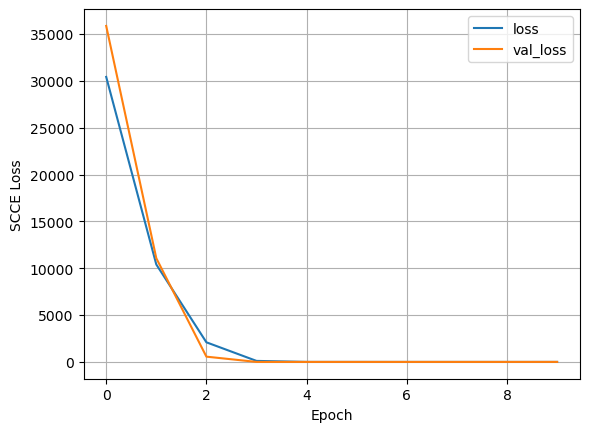

In [11]:
plt.plot(check_log.history['loss'], label='loss')
plt.plot(check_log.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('SCCE Loss') 
plt.legend()
plt.grid(True)

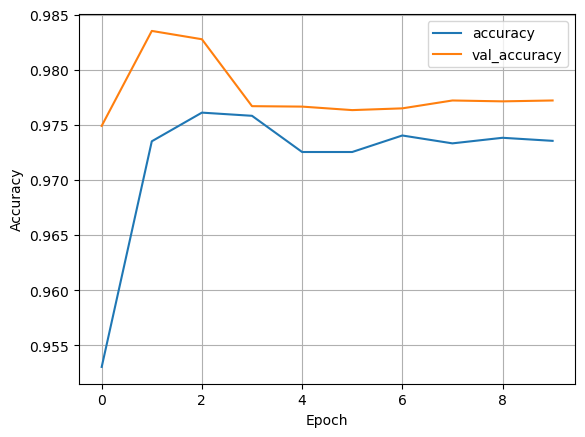

In [12]:
plt.plot(check_log.history['accuracy'], label='accuracy')
plt.plot(check_log.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

Using the Random Forest + Genetic Algorithm using the TPOT Library method

In [13]:
# define the parameter ranges to optimize
tpot_config = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    }
}
# setup the genetic algorithm
tpot = TPOTClassifier(generations=5,
                     population_size=20,
                     verbosity=2,
                     config_dict=tpot_config,
                     cv=5,
                     scoring='accuracy',
                     random_state=123)
# fit the model
tpot.fit(x_train, y_train)

is_classifier


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9989977850267294

Generation 2 - Current best internal CV score: 0.9991267833055477

Generation 3 - Current best internal CV score: 0.9991267833055477

Generation 4 - Current best internal CV score: 0.9991267833055477

Generation 5 - Current best internal CV score: 0.9991267833055477

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=4, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'bootstrap': [True,
                                                                                      False],
                                                                        'max_features': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                                                        'min_samples_leaf': range(1, 21),
                                                                        'min_samples_split': range(2, 21),
                                                                        'n_estimators': [100]}},
               generations=5, population_size=20, random_state=123,
               scoring='accuracy', verbosity=2)

In [14]:
rf_preds_binary = tpot.predict(x_test)
rf_preds_proba = tpot.predict_proba(x_test)[:, 1]

In [15]:
# TPOT model predictions
tpot_predictions = tpot.predict(x_test)

# Deep Learning model predictions
nn_predictions = (model.predict(x_test) > 0.5).astype("int32")

# Calculate metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Accuracy
print("TPOT Accuracy:", accuracy_score(y_test, tpot_predictions))
print("NN Accuracy:", accuracy_score(y_test, nn_predictions))

# Classification reports
print("TPOT Classification Report:\n", classification_report(y_test, tpot_predictions))
print("NN Classification Report:\n", classification_report(y_test, nn_predictions))

# AUC-ROC
print("TPOT AUC-ROC:", roc_auc_score(y_test, tpot.predict_proba(x_test)[:, 1]))
print("NN AUC-ROC:", roc_auc_score(y_test, model.predict(x_test).flatten()))

788/788 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step
TPOT Accuracy: 0.9989283588013494
NN Accuracy: 0.9772177019249851
TPOT Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     13386
           1       1.00      1.00      1.00     11809

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195

NN Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     13386
           1       0.99      0.96      0.98     11809

    accuracy                           0.98     25195
   macro avg       0.98      0.98      0.98     25195
weighted avg       0.98      0.98      0.98     25195

TPOT AUC-ROC: 0.9999968527652212
788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
NN AUC-ROC: 0.9980338734064127


788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


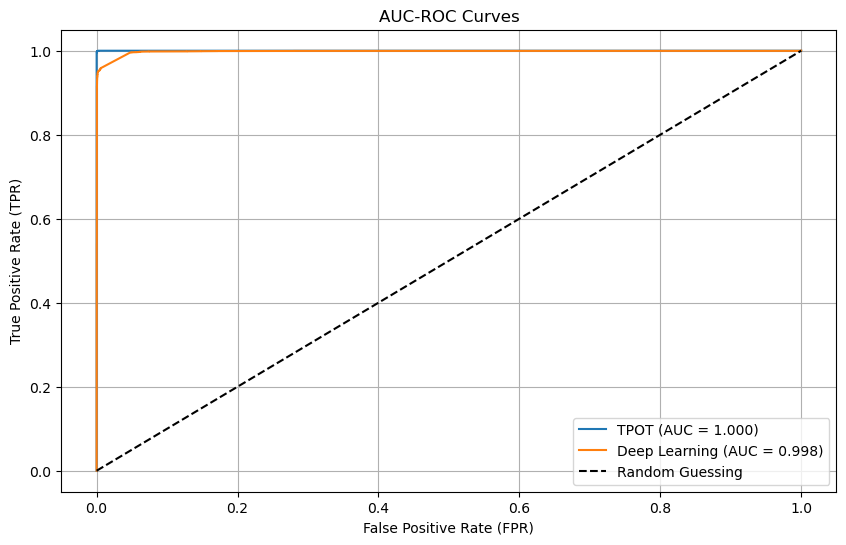

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# TPOT Predictions
tpot_probabilities = tpot.predict_proba(x_test)[:, 1]  # Get probabilities for class 1
tpot_fpr, tpot_tpr, _ = roc_curve(y_test, tpot_probabilities)
tpot_auc = roc_auc_score(y_test, tpot_probabilities)

# Deep Learning Predictions
nn_probabilities = model.predict(x_test).flatten()  # Get predicted probabilities
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probabilities)
nn_auc = roc_auc_score(y_test, nn_probabilities)

# Plot AUC-ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(tpot_fpr, tpot_tpr, label=f'TPOT (AUC = {tpot_auc:.3f})')
plt.plot(nn_fpr, nn_tpr, label=f'Deep Learning (AUC = {nn_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')  # Diagonal reference line
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('AUC-ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

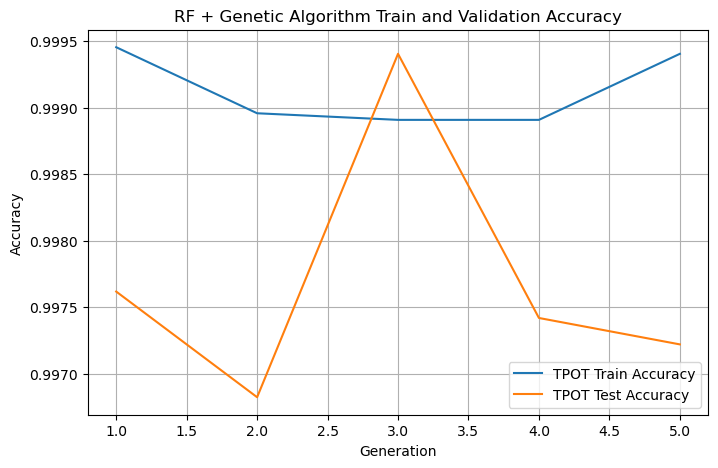

In [18]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Evaluate TPOT Model's Accuracy on Training and Test Data
tpot_train_accuracy = cross_val_score(tpot.fitted_pipeline_, x_train, y_train, cv=5, scoring='accuracy')
tpot_test_accuracy = cross_val_score(tpot.fitted_pipeline_, x_test, y_test, cv=5, scoring='accuracy')

# Simulated Accuracy for Plotting
epochs = range(1, len(tpot_train_accuracy) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, tpot_train_accuracy, label='TPOT Train Accuracy')
plt.plot(epochs, tpot_test_accuracy, label='TPOT Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.title('RF + Genetic Algorithm Train and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()